# 設定基本套件與環境變數

##### anaconda prompt
######  (base) C:\Users\sunny>conda activate zipline-tej
######  (zipline-tej) C:\Users\sunny>pip install TA_Lib-0.4.29-cp311-cp311-win_amd64.whl
######  (zipline-tej) C:\Users\sunny>jupyter notebook

In [1]:
import os    
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import talib

api_base = 'https://api.tej.com.tw'

os.environ['TEJAPI_BASE'] = api_base
os.environ['TEJAPI_KEY'] = tej_key


# 使用 get_universe() 函式取得股票池
##### ->股票池範圍 
##### (1)主產業別: 電子工業 
##### (2)證券種類: 普通股 
##### (3)板塊別: 上市一般版

In [2]:
from zipline.sources.TEJ_Api_Data import get_universe

#2022-06-01 2023-06-01
pool = get_universe(start = '2022-06-01', 
                    end = '2023-06-01', 
                    main_ind_c = 'M2300 電子工業',
                    stktp_e= 'Common Stock', 
                    mkt_bd_e=['TSE']) 
pool

Currently used TEJ API key call quota 544/1000 (54.4%)
Currently used TEJ API key data quota 3885348/10000000 (38.85%)


['1471',
 '1582',
 '2059',
 '2301',
 '2302',
 '2303',
 '2305',
 '2308',
 '2312',
 '2313',
 '2314',
 '2316',
 '2317',
 '2321',
 '2323',
 '2324',
 '2327',
 '2328',
 '2329',
 '2330',
 '2331',
 '2332',
 '2337',
 '2338',
 '2340',
 '2342',
 '2344',
 '2345',
 '2347',
 '2349',
 '2351',
 '2352',
 '2353',
 '2354',
 '2355',
 '2356',
 '2357',
 '2359',
 '2360',
 '2362',
 '2363',
 '2364',
 '2365',
 '2367',
 '2368',
 '2369',
 '2373',
 '2374',
 '2375',
 '2376',
 '2377',
 '2379',
 '2380',
 '2382',
 '2383',
 '2385',
 '2387',
 '2388',
 '2390',
 '2392',
 '2393',
 '2395',
 '2397',
 '2399',
 '2401',
 '2402',
 '2404',
 '2405',
 '2406',
 '2408',
 '2409',
 '2412',
 '2413',
 '2414',
 '2415',
 '2417',
 '2419',
 '2420',
 '2421',
 '2423',
 '2424',
 '2425',
 '2426',
 '2427',
 '2428',
 '2429',
 '2430',
 '2431',
 '2433',
 '2434',
 '2436',
 '2438',
 '2439',
 '2440',
 '2441',
 '2442',
 '2444',
 '2449',
 '2450',
 '2451',
 '2453',
 '2454',
 '2455',
 '2457',
 '2458',
 '2459',
 '2460',
 '2461',
 '2462',
 '2464',
 '2465',
 

In [7]:
len(pool)

407

# 利用 TejToolAPI 抓取所需的財務資料
##### ->選股條件
##### (1)最近年度毛利率>產業平均
##### (2)股票交易月平均周轉率>10%

In [3]:
import TejToolAPI

start_time = pd.Timestamp('2022-06-01')
end_time = pd.Timestamp('2023-06-01')  # 將時間字串轉換成時間格式

data = TejToolAPI.get_history_data(start = start_time,
                                   end = end_time,
                                   ticker = pool ,  
                                   fin_type = 'A', 
                                   columns = ['營業毛利率','周轉率'],
                                   transfer_to_chinese = True)

data

Currently used TEJ API key call quota 577/1000 (57.7%)
Currently used TEJ API key data quota 4172607/10000000 (41.73%)


,股票代碼,日期,周轉率,營業毛利率_A
0,1471,2022-06-01,0.8503,1.22
1,1471,2022-06-02,2.8953,1.22
2,1471,2022-06-06,1.3430,1.22
3,1471,2022-06-07,0.8024,1.22
4,1471,2022-06-08,0.8270,1.22
...,...,...,...,...
97927,9912,2023-05-26,0.0706,39.30
97928,9912,2023-05-29,0.1557,39.30
97929,9912,2023-05-30,0.0272,39.30
97930,9912,2023-05-31,0.1195,39.30


## 1.最近年度毛利率＞產業平均值

In [4]:
# 取出股票基本資料與 營業毛利率資料方便觀察
data_last_1Y = data[data['日期'] == '2023-06-01'].reset_index(drop = True)  
GM_1Y_data = data_last_1Y[['股票代碼', '日期', '營業毛利率_A']]
GM_1Y_data

,股票代碼,日期,營業毛利率_A
0,1471,2023-06-01,10.80
1,1582,2023-06-01,16.98
2,2059,2023-06-01,58.29
3,2301,2023-06-01,18.79
4,2302,2023-06-01,32.32
...,...,...,...
398,8215,2023-06-01,17.19
399,8249,2023-06-01,18.47
400,8261,2023-06-01,26.34
401,8271,2023-06-01,22.36


In [5]:
# 計算出產業平均營業毛利率
industry_GM_ave = GM_1Y_data["營業毛利率_A"].mean()

# 加入 '產業平均毛利率' 欄位
GM_1Y_data['產業平均毛利率'] = industry_GM_ave

GM_1Y_data

,股票代碼,日期,營業毛利率_A,產業平均毛利率
0,1471,2023-06-01,10.80,21.011166
1,1582,2023-06-01,16.98,21.011166
2,2059,2023-06-01,58.29,21.011166
3,2301,2023-06-01,18.79,21.011166
4,2302,2023-06-01,32.32,21.011166
...,...,...,...,...
398,8215,2023-06-01,17.19,21.011166
399,8249,2023-06-01,18.47,21.011166
400,8261,2023-06-01,26.34,21.011166
401,8271,2023-06-01,22.36,21.011166


In [6]:
# 篩選符合選股條件1.的公司
set_1 = set(GM_1Y_data[GM_1Y_data['營業毛利率_A'] > GM_1Y_data['產業平均毛利率']]['股票代碼'])
set_1
len(set_1)

179

## 2. 最近月平均周轉率>10%

In [7]:
#挑選2023-05每個交易日的周轉率
data_last_2Y = data[data['日期'].isin(['2023-05-01', '2023-06-01'])].reset_index(drop = True) 
#計算個股的周轉率平均
turnover_2Y_ave = data_last_2Y.groupby('股票代碼')['周轉率'].mean()

turnover_2Y_ave = pd.DataFrame(turnover_2Y_ave).rename(columns = {'周轉率': '月平均周轉率'})

turnover_2Y_ave

,月平均周轉率
股票代碼,
1471,0.3065
1582,0.0881
2059,0.6464
2301,0.5764
2302,4.5537
...,...
8215,0.7665
8249,0.1858
8261,2.1656


In [8]:
# 篩選符合選股條件的公司
set_2 = set(turnover_2Y_ave[turnover_2Y_ave['月平均周轉率'] > 10].index)  # 篩選符合選股條件的公司
set_2
len(set_2)

10

In [9]:
tickers = list(set_1 & set_2)
tickers

['8271', '6235', '5258', '3025', '2482', '2457']

# 回測股票池買賣一年的績效

#### 導入股價資料(要改ticker)

In [128]:
start = '2022-08-01'
end = '2022-12-31'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = '8271'

!zipline ingest -b tquant 
# 填入：將價量資料導入的程式碼

Merging daily equity files:
Currently used TEJ API key call quota 761/1000 (76.1%)
Currently used TEJ API key data quota 4786367/10000000 (47.86%)


[2024-06-13 07:51:16.819104] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-06-13 07:51:20.555933] INFO: zipline.data.bundles.core: Ingest tquant successfully.


# 建立 initialize 函式
##### commission手續費模型: PerDollar按照交易金額抽成計算  (抽成0.285%)
##### slippage滑價模型: VolumeShareSlippage根據該筆交易佔總交易量百分比來計算滑價，並可設定成交量限制 (交易限制2.5%)

In [129]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.sym = symbol(os.environ['ticker'])
    context.i = 0
    context.invested = False
    context.set_commission(commission.PerDollar(cost=0.00285))
    context.set_slippage(slippage.VolumeShareSlippage(volume_limit=0.025, price_impact=0.1))
    

# 建立 handle_data 函式

#### ->MACD參數
###### 短期指數移動平均線:12日
###### 長期指數移動平均線:26日
###### DIF:9日指數移動平均線

#### ->RSI參數
###### 取14天內的平均漲幅跌幅

#### ->設定交易策略
###### (1)MACD線上漲並穿過信號線 且 RSI >50 >>買進
###### (2)MACD線下跌並穿過信號線 且 RSI <50 >>賣出

In [130]:
def handle_data(context, data):
    trailing_window = data.history(context.sym, 'price', 35, '1d')#35 = 26 + 9
    if trailing_window.isnull().values.any():
        return

    short_ema = talib.EMA(trailing_window.values, timeperiod = 12)
    long_ema = talib.EMA(trailing_window.values, timeperiod = 26)
    dif = short_ema - long_ema
    MACD = talib.EMA(dif, timeperiod = 9)
    bar = dif - MACD
    rsi14 = talib.RSI(trailing_window.values, timeperiod=14)
    buy = False
    sell = False

    # Trading logic
    #condition1
    if (dif[-2] < MACD[-2]) and (dif[-1] > MACD[-1]) and (bar[-2] < 0) and (bar[-1] > 0) and (rsi14[-1] > 50):
        order_target(context.sym, 1000)
        context.invested = True
        buy = True
    
    #condition2
    elif (dif[-2] > MACD[-2]) and (dif[-1] < MACD[-1]) and (bar[-2] > 0) and (bar[-1] < 0) and (rsi14[-1] < 50) and context.invested:
        order_target(context.sym, 0)
        context.invested = False
        sell = True
        
    # Save values for later inspection
    record(stock_name = data.current(symbol(os.environ['ticker']), 'close'),
           dif = dif[-1],
           MACD = MACD[-1],
           bar = bar[-1],
           rsi14=rsi14[-1],
           buy = buy,
           sell = sell)



# 建立 analyze 函式

In [131]:
def analyze(context=None, results=None):
    import matplotlib.pyplot as plt
    import logbook
    logbook.StderrHandler().push_application()
    log = logbook.Logger('Algorithm')


    capital_base = 1e6
    #畫portfolio_value
    fig = plt.figure()
    ax1 = fig.add_subplot(311)
    #results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    #results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    results.portfolio_value.plot(ax=ax1,title='portfolio values')
    ax1.set_ylabel('Portfolio value (TWD)')

    #畫MACD(曲線和BAR)
    ax2 = fig.add_subplot(312, sharex = ax1,title='MACD')
    ax2.set_ylabel('MACD')

    if 'dif' in results and 'MACD' in results:
        results[['dif', 'MACD']].plot(ax=ax2)
        ax2.plot(
            results.index[results["buy"] == True],
            results.loc[results["buy"] == True, 'MACD'],
            '^',
            markersize=10,
            color='m',
        )
        ax2.plot(
            results.index[results["sell"] == True],
            results.loc[results["sell"] == True, 'MACD'],
            'v',
            markersize=10,
            color='k',
        )

        ax3 = ax2.twinx()
        colors = ["red" if i > 0 else "green" for i in results['bar']]
        ax3.bar(results.index, results['bar'], color=colors, alpha=0.5, width=0.4, label='MACD Bar')
        
        lines, labels = ax2.get_legend_handles_labels()
        bars, bar_labels = ax3.get_legend_handles_labels()
        ax2.legend(lines + bars, labels + bar_labels, loc='upper right')
        
        plt.gcf().set_size_inches(18, 8)

    else:
        msg = ' dif and MACD data not captured using record().'
        ax2.annotate(msg, xy=(0.1, 0.5))
        log.info(msg)

    #畫RSI
    ax4 = fig.add_subplot(313, sharex = ax1,title='RSI')
    if 'rsi14' in results:
        ax4.plot(results.index, results['rsi14'], label='RSI14', color='blue')
        ax4.set_ylabel('RSI14')
        ax4.legend()


    plt.show()

# 執行交易策略

[2024-06-13 07:51:41.314463] INFO: zipline.finance.metrics.tracker: Simulated 108 trading days
first open: 2022-08-01 01:01:00+00:00
last close: 2022-12-30 05:30:00+00:00


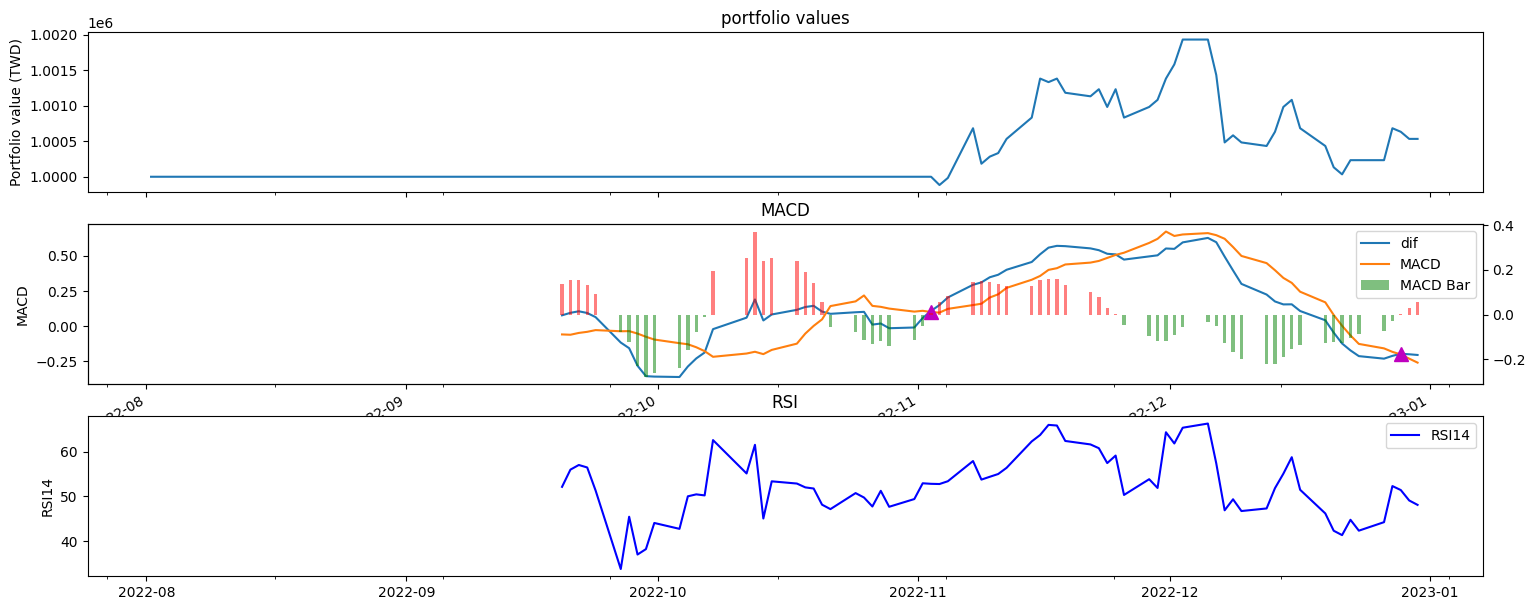

In [133]:
from zipline import run_algorithm

start_date = pd.Timestamp('2022-08-01',tz='utc')
end_date = pd.Timestamp('2022-12-31',tz='utc')

results = run_algorithm(start= start_date,  
                       end=end_date,
                       initialize=initialize,                       
                       capital_base=1e6,
                       analyze=analyze,
                       handle_data=handle_data,
                       data_frequency='daily',
                       bundle='tquant'
                       )

<Axes: >

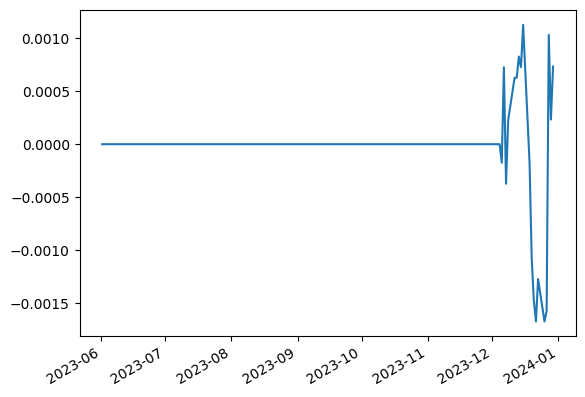

In [83]:
results.returns.cumsum().plot()  
# 繪製累積回報圖

# 投資組合 sharpe ration

In [121]:
start = '2023-06-01'
end = '2023-12-31'


#print(tickers)
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'


!zipline ingest -b tquant 

['8271', '6235', '5258', '3025', '2482', '2457']
Merging daily equity files:
Currently used TEJ API key call quota 757/1000 (75.7%)
Currently used TEJ API key data quota 4784385/10000000 (47.84%)


[2024-06-13 07:45:25.028137] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-06-13 07:45:28.182060] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [122]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    context.day = 0
    context.tickers = tickers
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1)) # 填入：本範例使用的滑價模型
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))  # 填入：本範例使用的手續費模型
    set_benchmark(symbol('IR0001'))

In [123]:
def handle_data(context, data):
    
    trailing_window = data.history(context.sym, 'price', 35, '1d')#35 = 26 + 9
    if trailing_window.isnull().values.any():
        return

    short_ema = talib.EMA(trailing_window.values, timeperiod = 12)
    long_ema = talib.EMA(trailing_window.values, timeperiod = 26)
    dif = short_ema - long_ema
    MACD = talib.EMA(dif, timeperiod = 9)
    bar = dif - MACD
    rsi14 = talib.RSI(trailing_window.values, timeperiod=14)
    buy = False
    sell = False

    # Trading logic
    #condition1
    if (dif[-2] < MACD[-2]) and (dif[-1] > MACD[-1]) and (bar[-2] < 0) and (bar[-1] > 0) and (rsi14[-1] > 50):
        order_target(context.sym, 1000)
        context.invested = True
        buy = True
    
    #condition2
    elif (dif[-2] > MACD[-2]) and (dif[-1] < MACD[-1]) and (bar[-2] > 0) and (bar[-1] < 0) and (rsi14[-1] < 50) and context.invested:
        order_target(context.sym, 0)
        context.invested = False
        sell = True
        
    # Save values for later inspection
    record(stock_name = data.current(symbol(tickers), 'close'),
           dif = dif[-1],
           MACD = MACD[-1],
           bar = bar[-1],
           rsi14=rsi14[-1],
           buy = buy,
           sell = sell)

In [125]:
import matplotlib.pyplot as plt
capital_base = 1e6
def analyze(context=None, results=None):

    #畫portfolio_value
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    results['benchmark_cum'] = results.benchmark_return.add(1).cumprod() * capital_base
    results[['portfolio_value', 'benchmark_cum']].plot(ax = ax1, label = 'Portfolio Value($)')
    #results.portfolio_value.plot(ax=ax1,title='portfolio values')
    ax1.set_ylabel('Portfolio value (TWD)')
    plt.legend(loc = 'upper left')
    plt.gcf().set_size_inches(18, 8)
    plt.grid()
    plt.show()

In [127]:
from zipline import run_algorithm
from zipline.utils.run_algo import get_transaction_detail

start_date = pd.Timestamp('2023-06-01',tz='utc')
end_date = pd.Timestamp('2023-12-31',tz='utc')

results = run_algorithm(start= start_date,  
                       end=end_date,
                       initialize=initialize,                       
                       capital_base=capital_base,
                       analyze=analyze,
                       handle_data=handle_data,
                       data_frequency='daily',
                       )

AttributeError: 'TradingAlgorithm' object has no attribute 'sym'

In [ ]:
from pyfolio.utils import extract_rets_pos_txn_from_zipline
import pyfolio

returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)  # 從 results 資料表中取出 returns, positions & transactions
benchmark_rets = results.benchmark_return  # 取出 benchmark 的報酬率

# 繪製夏普比率圖

from pyfolio.plotting import plot_rolling_sharpe

plot_rolling_sharpe(returns,
                    factor_returns=benchmark_rets)